Целью текущего соревнования является построение алгоритма для определения мошеннических транзакций путем применения подходов и моделей машинного обучения к обфусцированной исторической выборке, предоставленной Vesta Corporation.

В переводе на предметную терминологию, перед нами стоит задача бинарной классификации.

## Импорт данных и библиотек

In [1]:
import numpy as np 
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn import preprocessing
import xgboost as xgb
from sklearn.model_selection import KFold, train_test_split
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt
import lightgbm as lgb
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV, cross_val_score, StratifiedKFold, learning_curve
import datetime
from sklearn.metrics import confusion_matrix
%matplotlib inline

In [2]:
file_path = 'D:\Kaggle\IEEE-CIS Fraud Detection'

In [3]:
train_transaction = pd.read_csv(r'{}\train_transaction.csv'.format(file_path), index_col='TransactionID')
test_transaction = pd.read_csv(r'{}\test_transaction.csv'.format(file_path), index_col='TransactionID')

train_identity = pd.read_csv(r'{}\train_identity.csv'.format(file_path), index_col='TransactionID')
test_identity = pd.read_csv(r'{}\test_identity.csv'.format(file_path), index_col='TransactionID')

sample_submission = pd.read_csv(r'{}\sample_submission.csv'.format(file_path), index_col='TransactionID')

## Предобработка

На время предварительной обработки и анализа - объеденим тестовую и тренировочную выборки в одну

In [4]:
train = train_transaction.merge(train_identity, how='left', left_index=True, right_index=True)
test = test_transaction.merge(test_identity, how='left', left_index=True, right_index=True)

print(train.shape)
print(test.shape)

y_train = train['isFraud'].copy()

(590540, 433)
(506691, 432)


In [5]:
train_len = len(train)
df = pd.concat(objs=[train, test], axis=0, sort=False)
print(df.shape)
df.head()

(1097231, 433)


,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,card6,...,id_31,id_32,id_33,id_34,id_35,id_36,id_37,id_38,DeviceType,DeviceInfo
TransactionID,,,,,,,,,,,,,,,,,,,,,
2987000,0.0,86400,68.5,W,13926,NaN,150.0,discover,142.0,credit,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2987001,0.0,86401,29.0,W,2755,404.0,150.0,mastercard,102.0,credit,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2987002,0.0,86469,59.0,W,4663,490.0,150.0,visa,166.0,debit,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2987003,0.0,86499,50.0,W,18132,567.0,150.0,mastercard,117.0,debit,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2987004,0.0,86506,50.0,H,4497,514.0,150.0,mastercard,102.0,credit,...,samsung browser 6.2,32.0,2220x1080,match_status:2,T,F,T,T,mobile,SAMSUNG SM-G892A Build/NRD90M


Сразу очистим память путем кдаления переменных, которые больше не будут использованы напрямую, по скольку были агрегированы в более полезные сущности

In [6]:
del train_transaction, train_identity, test_transaction, test_identity

Начнем знакомство с данными посмотрев на количество пропущенных значений

In [7]:
cols = df.isna().sum()
cols[cols == 0]

TransactionDT     0
TransactionAmt    0
ProductCD         0
card1             0
dtype: int64

Только 4 колонки из 433 не содержат пропущенных значений, с учетом того, что пропуски в колонке isFraud обусловлены отсутствием нужных значений в тестовой выборке.

Оценим ситцуацию более предметно, используя процентное соотношение для большей наглядности

In [8]:
nans_df = pd.DataFrame({
    'feature': df.columns, 
    'nan_number': [(df[col].isna().sum())/df.shape[0]*100 for col in df.columns]
})
nans_df.sort_values(by=['nan_number'], ascending=False, inplace=True)

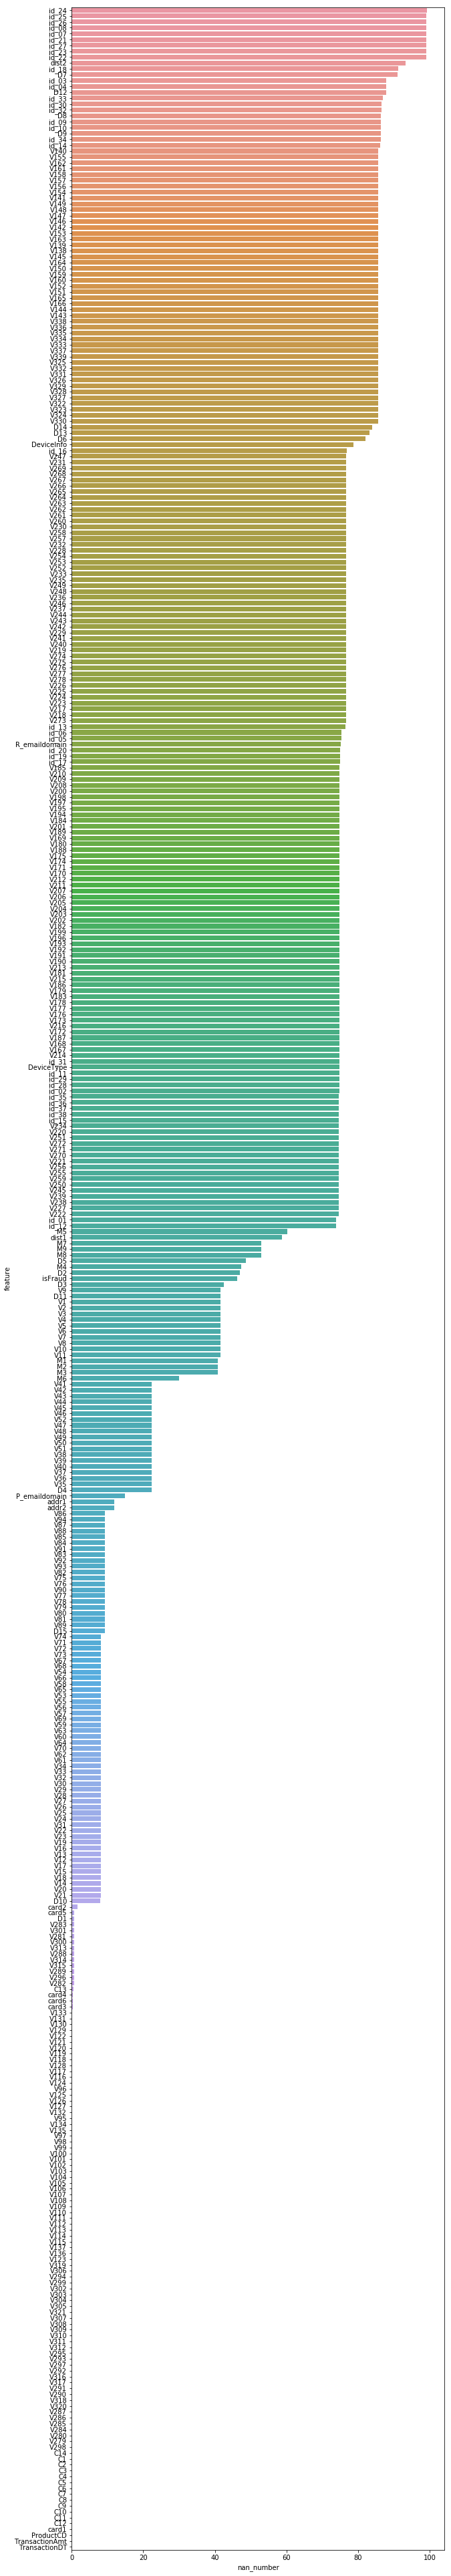

In [9]:
plt.figure(figsize=(10, 70))
ax = sns.barplot(x="nan_number", y="feature", data=nans_df)

In [10]:
min_nans = list(nans_df[nans_df['nan_number']  < 1]['feature'])
df[min_nans].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1097231 entries, 2987000 to 4170239
Columns: 109 entries, card5 to TransactionDT
dtypes: float64(104), int64(2), object(3)
memory usage: 920.8+ MB


Категориальные признаки пока оставим, остальные избавим от пропущенных значений путем замены на медианное

In [11]:
categor_min_nans = list(df[min_nans].select_dtypes(include='object').columns)
min_nans = list(set(min_nans).difference(categor_min_nans))
df[min_nans] = df[min_nans].fillna(df[min_nans].median())

Для дальнейших действий было бы неплохо посмотреть на степень корреляции каждого отдельного признака с целевой переменной

In [12]:
train_corrs = train.corr()
train_corrs.head()

,isFraud,TransactionDT,TransactionAmt,card1,card2,card3,card5,addr1,addr2,dist1,...,id_17,id_18,id_19,id_20,id_21,id_22,id_24,id_25,id_26,id_32
isFraud,1.000000,0.013103,0.011320,-0.013640,0.003388,0.154151,-0.033580,0.005596,-0.030387,0.021522,...,0.150100,0.050004,-0.041721,0.061597,0.063544,0.118409,-0.001905,0.034045,0.099587,0.069702
TransactionDT,0.013103,1.000000,0.011920,0.010625,-0.019202,-0.011222,-0.024132,-0.000051,0.051972,-0.027295,...,0.214802,0.110234,-0.011815,0.082009,-0.024249,0.051437,-0.031312,0.020372,0.017790,-0.071392
TransactionAmt,0.011320,0.011920,1.000000,-0.005725,0.016136,-0.109785,0.003061,-0.007421,0.028312,0.026146,...,-0.334971,-0.096851,0.076174,-0.105866,-0.031840,-0.104620,0.080110,0.016145,0.023098,-0.041851
card1,-0.013640,0.010625,-0.005725,1.000000,0.004960,0.002965,-0.093633,0.020369,-0.000060,0.005152,...,0.018892,0.008869,0.022617,0.015917,0.044073,0.016853,0.057550,-0.010192,0.078487,-0.009524
card2,0.003388,-0.019202,0.016136,0.004960,1.000000,0.023816,0.030486,0.030356,-0.022383,-0.013374,...,-0.038135,-0.012282,0.016537,-0.006812,0.002807,-0.024013,0.000844,-0.009787,0.006429,-0.031503


In [13]:
top_corr = train_corrs['isFraud'].abs().sort_values(ascending=False)[:10]
top_corr

isFraud    1.000000
V257       0.383060
V246       0.366878
V244       0.364129
V242       0.360590
V201       0.328005
V200       0.318783
V189       0.308219
V188       0.303582
V258       0.297151
Name: isFraud, dtype: float64

C:\ProgramData\Anaconda3\lib\site-packages\numpy\lib\histograms.py:824: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
C:\ProgramData\Anaconda3\lib\site-packages\numpy\lib\histograms.py:825: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


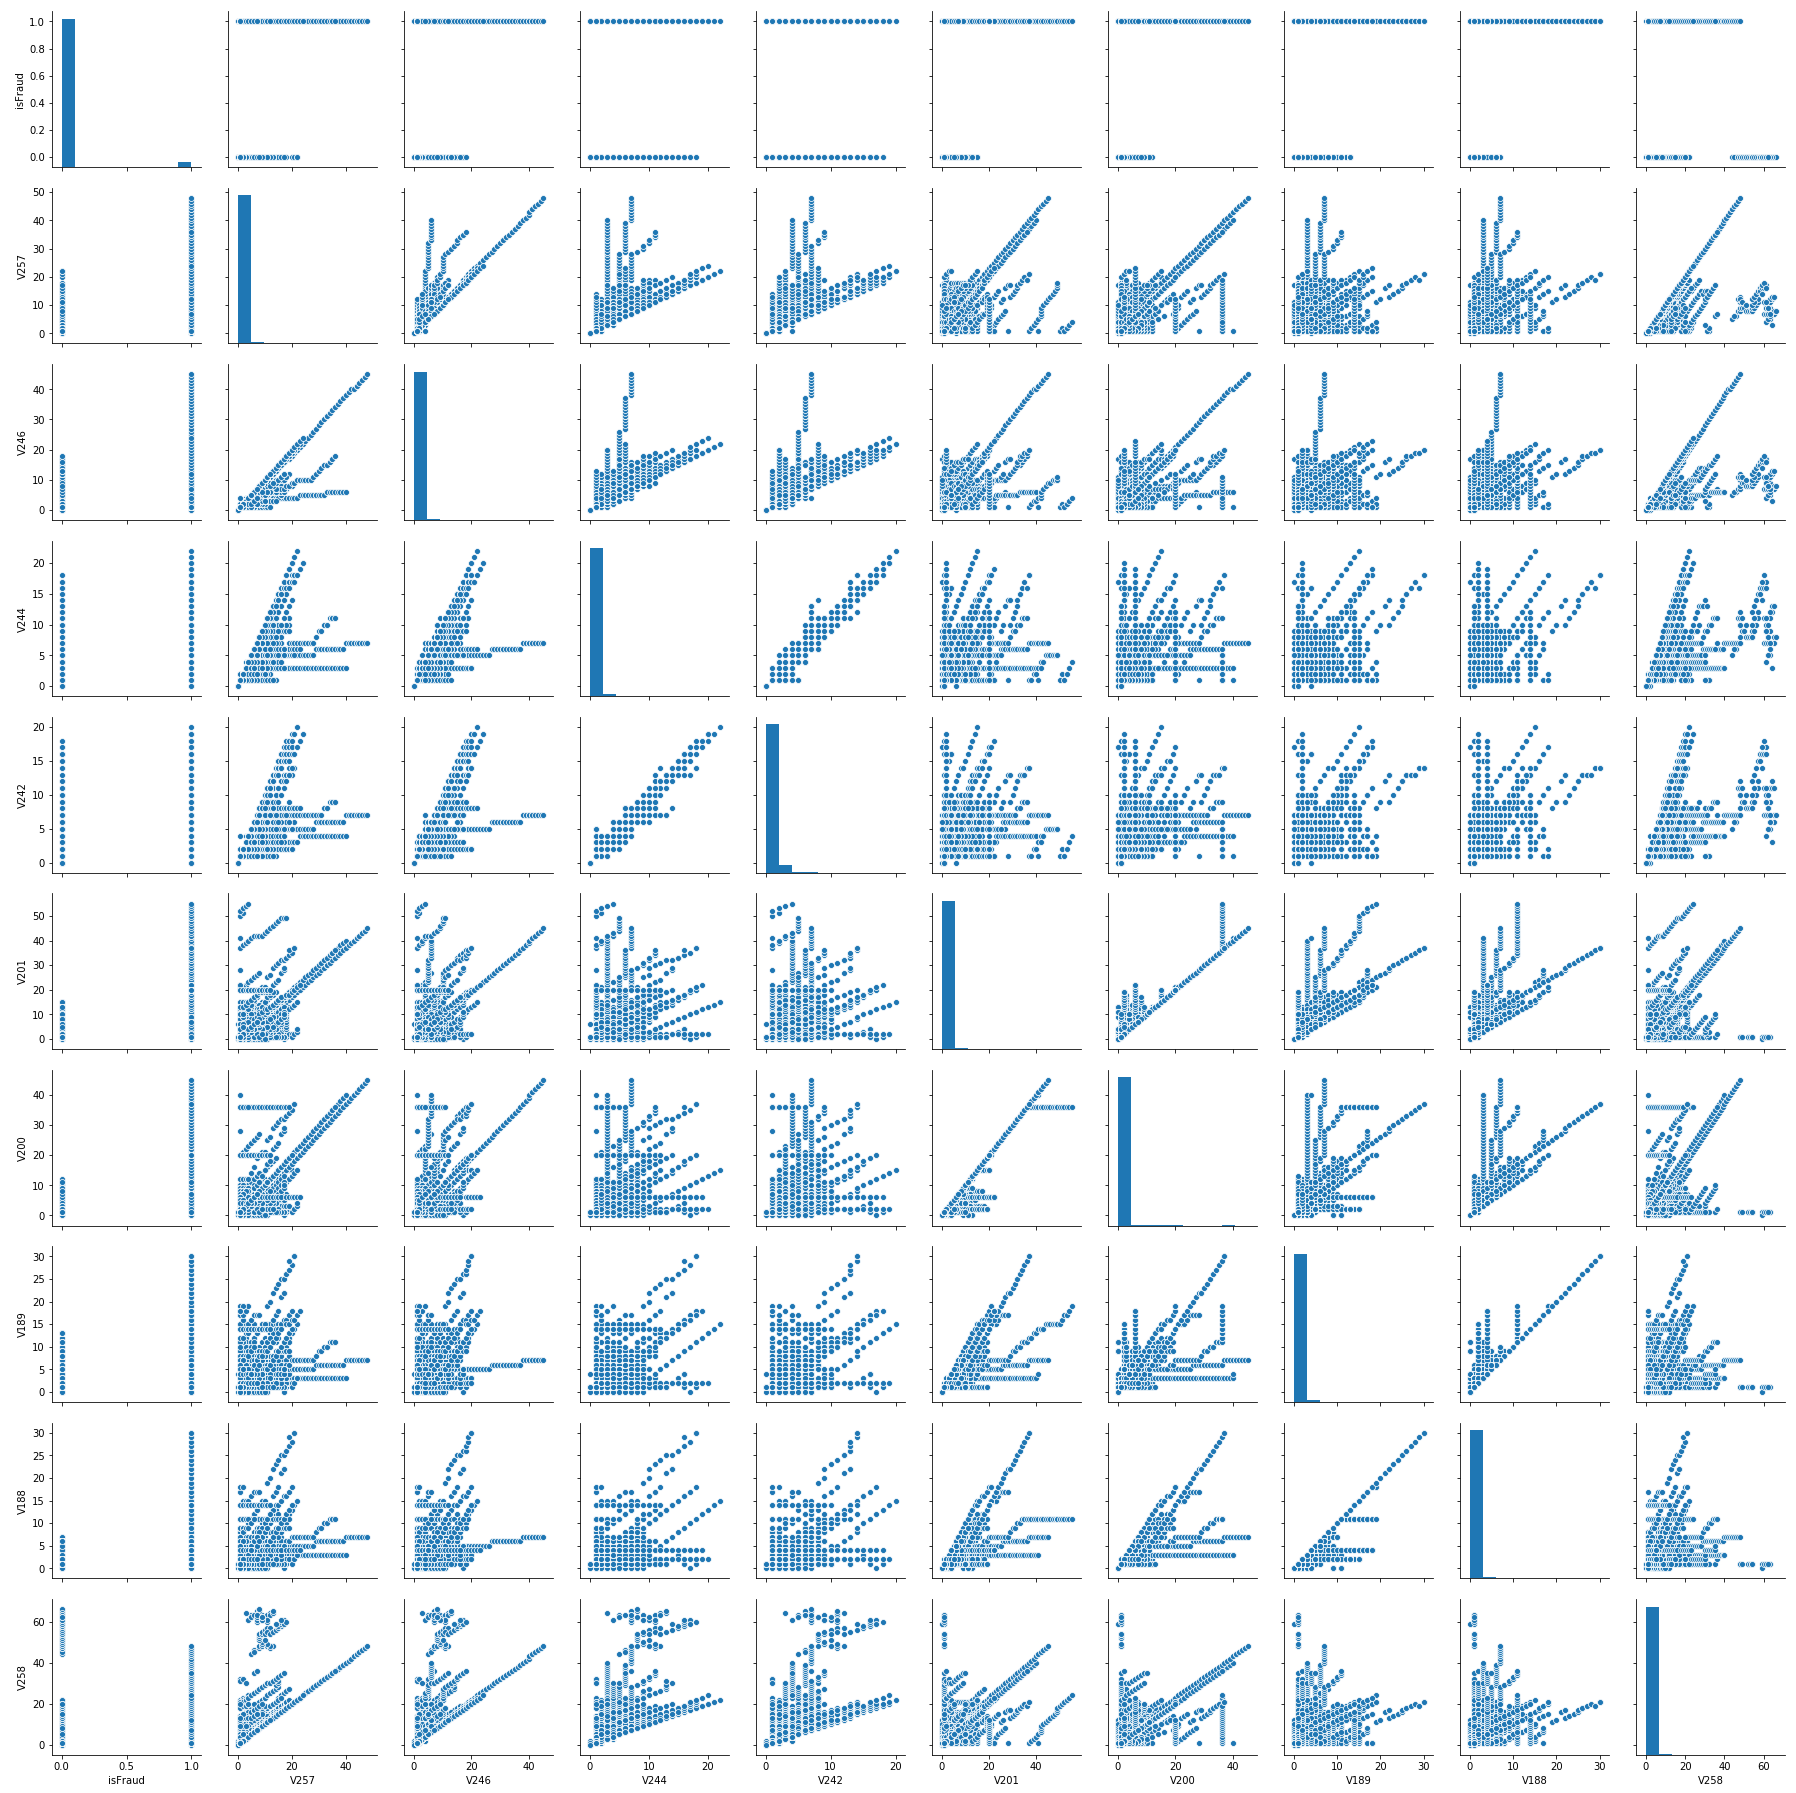

In [14]:
#sns.pairplot(df[top_corr.index])
sns.pairplot(train[top_corr.index])

Признаки с наибольшей корреляцией попадают под категорию VXXX и представляют собой неизвестные метрики, в описании датасета сказано, что они содержат ранжирование, подсчет и другие отношения сущностей.

По этой причине сложно как либо интерпритировать к примеру линейную зависимость между некоторыми из них или интересное соотношение V258 к таргету.

In [15]:
binary_columns = [col for col in df.columns if len(df[col].value_counts()) == 2]
binary_columns

['isFraud',
 'M1',
 'M2',
 'M3',
 'M5',
 'M6',
 'M7',
 'M8',
 'M9',
 'V1',
 'V14',
 'V41',
 'V65',
 'V88',
 'V107',
 'V305',
 'id_12',
 'id_16',
 'id_27',
 'id_28',
 'id_29',
 'id_35',
 'id_36',
 'id_37',
 'id_38',
 'DeviceType']

Среди колонок, содержащих бинарные значения мы видим большую часть признаков, обозначеных в легенде как признаки, инфоримрующие о наличии неких совпадений, например имена на карте и адрес и т. д.

Воспользуемся этим, чтобы создать еще два новых признака:

In [17]:
m_cols = ['M1','M2','M3','M5','M6','M7','M8','M9']
df[m_cols] = df[m_cols].replace({'T': 1, 'F': 0})
df['M_sum'] = df[m_cols].sum(axis=1).astype(np.int8)
df['M_sum'].value_counts()

0    361431
4    180358
5    173215
3    100489
6     97237
1     89855
2     44729
7     42977
8      6940
Name: M_sum, dtype: int64

In [18]:
df['M_na'] = df[m_cols].isna().sum(axis=1).astype(np.int8)
df['M_na'].value_counts()

8    301513
0    257713
1    247764
3     88575
6     75191
7     69598
4     45702
2      9061
5      2114
Name: M_na, dtype: int64

Колонка TransactionDT содержит timedelta из заданной контрольной даты и времени (2017-11-30), что не является фактической датой и контрольная дата нам не известна, но этот признак должен сохранить зависимость после такого рода преобразования (если она есть)

In [19]:
START_DATE = datetime.datetime.strptime('2017-11-30', '%Y-%m-%d')
df['DT'] = df['TransactionDT'].apply(lambda x: (START_DATE + datetime.timedelta(seconds = x)))
df['DT_M'] = (df['DT'].dt.year-2017)*12 + df['DT'].dt.month
df['DT_W'] = (df['DT'].dt.year-2017)*52 + df['DT'].dt.weekofyear
df['DT_D'] = (df['DT'].dt.year-2017)*365 + df['DT'].dt.dayofyear

df['DT_hour'] = df['DT'].dt.hour
df['DT_day_week'] = df['DT'].dt.dayofweek
df['DT_day'] = df['DT'].dt.day
df.drop(['DT'], axis=1, inplace=True)

Процент пропущенных целочисленных значений все еще достаточно велик, а отсутствие контекста и понимания природы признаков не дает нам возможности рассуждать о том, какими значениями можно заменить нан в том или ином случае (квартильные, медианные и проч), а их количество исключает удаление объектов, содержащих пропуски. Поэтому воспользуемся средствами библиотеки xgboost, которая постарается сама должным образом обработать nanы

In [20]:
df = df.fillna(-999)

In [21]:
for f in df.columns:
    if df[f].dtype=='object' or df[f].dtype=='object': 
        lbl = preprocessing.LabelEncoder()
        lbl.fit(list(df[f].values) + list(df[f].values))
        df[f] = lbl.transform(list(df[f].values))

In [22]:
train = df[:train_len]
test = df[train_len:]
print(train.shape)
print(test.shape)

(590540, 441)
(506691, 441)


In [23]:
X_train = train.drop('isFraud', axis=1)
X_test = test.drop('isFraud', axis=1).copy()

In [24]:
del df, train, test, nans_df, binary_columns, train_corrs

In [25]:
trX_train, trX_test, try_train, try_test = train_test_split(X_train, y_train, test_size=0.33, random_state=42)

In [26]:
def quik_test(quik_X_train, quik_y_train, quik_X_test, quik_y_test, clf='lgbclf'):
    
    lgbclf = lgb.LGBMClassifier(
        num_leaves= 512,
        n_estimators=512,
        max_depth=9,
        learning_rate=0.064,
        subsample=0.85,
        colsample_bytree=0.85,
        boosting_type= "gbdt",
        reg_alpha=0.3,
        reg_lamdba=0.243
    )
    
    xgbclf = xgb.XGBClassifier(n_estimators=500,
                        n_jobs=-1,
                        max_depth=9,
                        learning_rate=0.05,
                        subsample=0.9,
                        colsample_bytree=0.9,
                        missing=-999)
       
    classificators = {'lgbclf': lgbclf, 'xgbclf': xgbclf}
    
    clf = classificators[clf]
    clf.fit(quik_X_train, quik_y_train)
    quik_predict = clf.predict(quik_X_test)
    
    print(clf)
    print("Accuracy: {}".format(accuracy_score(quik_y_test, quik_predict)))
    print(confusion_matrix(quik_y_test, quik_predict))
    print("Roc Auc: {}".format(roc_auc_score(quik_y_test, quik_predict)))
    
    return clf

In [27]:
quik_test(trX_train, try_train, trX_test, try_test)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=0.85,
        importance_type='split', learning_rate=0.064, max_depth=9,
        min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
        n_estimators=512, n_jobs=-1, num_leaves=512, objective=None,
        random_state=None, reg_alpha=0.3, reg_lambda=0.0, reg_lamdba=0.243,
        silent=True, subsample=0.85, subsample_for_bin=200000,
        subsample_freq=0)
Accuracy: 0.9847956937381658
[[187741    192]
 [  2771   4175]]
Roc Auc: 0.8000218603339792


LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=0.85,
        importance_type='split', learning_rate=0.064, max_depth=9,
        min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
        n_estimators=512, n_jobs=-1, num_leaves=512, objective=None,
        random_state=None, reg_alpha=0.3, reg_lambda=0.0, reg_lamdba=0.243,
        silent=True, subsample=0.85, subsample_for_bin=200000,
        subsample_freq=0)

In [29]:
quik_test(trX_train, try_train, trX_test, try_test, 'xgbclf')

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bynode=1, colsample_bytree=0.9, gamma=0,
       learning_rate=0.05, max_delta_step=0, max_depth=9,
       min_child_weight=1, missing=-999, n_estimators=500, n_jobs=-1,
       nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=None, subsample=0.9, verbosity=1)
Accuracy: 0.9834564011514837
[[187719    214]
 [  3010   3936]]
Roc Auc: 0.7827591825648164


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bynode=1, colsample_bytree=0.9, gamma=0,
       learning_rate=0.05, max_delta_step=0, max_depth=9,
       min_child_weight=1, missing=-999, n_estimators=500, n_jobs=-1,
       nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=None, subsample=0.9, verbosity=1)

In [30]:
lgbclf = lgb.LGBMClassifier(
    num_leaves= 512,
    n_estimators=512,
    max_depth=9,
    learning_rate=0.064,
    subsample=0.85,
    colsample_bytree=0.85,
    boosting_type= "gbdt",
    reg_alpha=0.3,
    reg_lamdba=0.243
)


lgbclf.fit(X_train, y_train)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=0.85,
        importance_type='split', learning_rate=0.064, max_depth=9,
        min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
        n_estimators=512, n_jobs=-1, num_leaves=512, objective=None,
        random_state=None, reg_alpha=0.3, reg_lambda=0.0, reg_lamdba=0.243,
        silent=True, subsample=0.85, subsample_for_bin=200000,
        subsample_freq=0)

In [31]:
sample_submission = pd.read_csv(r'{}\sample_submission.csv'.format(file_path), index_col='TransactionID')
sample_submission['isFraud'] = lgbclf.predict_proba(X_test)[:,1]
sample_submission.to_csv('lgb_with_features.csv')

In [32]:
clf = xgb.XGBClassifier(n_estimators=500,
                        n_jobs=-1,
                        max_depth=9,
                        learning_rate=0.05,
                        subsample=0.9,
                        colsample_bytree=0.9,
                        missing=-999)

clf.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bynode=1, colsample_bytree=0.9, gamma=0,
       learning_rate=0.05, max_delta_step=0, max_depth=9,
       min_child_weight=1, missing=-999, n_estimators=500, n_jobs=-1,
       nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=None, subsample=0.9, verbosity=1)

In [33]:
sample_submission = pd.read_csv(r'{}\sample_submission.csv'.format(file_path), index_col='TransactionID')
sample_submission['isFraud'] = clf.predict_proba(X_test)[:,1]
sample_submission.to_csv('xgb_with_features.csv')